# AMPSphere v.2022-03

This is a notebook meant to form the set of notebooks used to analyze the data in AMPSphere and write the manuscript:

__AMPSphere: Global survey of prokaryotic antimicrobial peptides shaping microbiomes__

Figures generated in this script formed the panel shown in Figure 1 and S2.

### Metadata exploration

Exploration of metadata of metagenomes used in the AMPSphere.

In [1]:
# load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib import cm
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests

plt.rcParams['svg.fonttype'] = 'none'

In [2]:
higher_level = {'sediment' : 'other',
        'bird gut' : 'other animal',
        'cat gut' : 'mammal gut',
        'insect associated' : 'other animal',
        'human urogenital tract' : 'other human',
        'dog gut' : 'mammal gut',
        'fermented food' : 'anthropogenic',
        'groundwater' : 'aquatic',
        'coral associated' : 'other animal',
        'rat gut' : 'mammal gut',
        'human associated' : 'other human',
        'cattle gut' : 'mammal gut',
        'deer gut' : 'mammal gut',
        'mouse gut' : 'mammal gut',
        'river associated' : 'aquatic',
        'primate gut' : 'mammal gut',
        'human respiratory tract' : 'other human',
        'cattle rumen' : 'other animal',
        'human saliva' : 'other human',
        'activated sludge' : 'anthropogenic',
        'lake associated' : 'aquatic',
        'wastewater' : 'anthropogenic',
        'chicken gut' : 'other animal',
        'air' : 'other',
        'human mouth' : 'other human',
        'plant associated' : 'soil/plant',
        'water associated' : 'aquatic',
        'pig gut' : 'mammal gut',
        'human skin' : 'other human',
        'marine' : 'aquatic',
        'soil' : 'soil/plant',
        'built environment' : 'anthropogenic',
        'human gut' : 'human gut',
        'anthropogenic': 'anthropogenic',
        'bear gut' : 'mammal gut',
        'pond associated': 'aquatic',
        'bee gut': 'other animal',
        'bat gut': 'mammal gut',
        'dog associated': 'other animal',
        'cattle associated': 'other animal',
        'crustacean associated': 'other animal',
        'insect gut': 'other animal',
        'goat gut': 'mammal gut', 
        'rodent gut': 'mammal gut',
        'fisher gut': 'mammal gut',
        'human digestive tract': 'other human',
        'coyote gut': 'mammal gut',
        'planarian associated': 'other animal',
        'sponge associated': 'other animal',
        'goat rumen': 'other animal',
        'crustacean gut': 'other animal',
        'annelidae associated': 'other animal',
        'bird skin': 'other animal',
        'beatle gut': 'other animal',
        'termite gut': 'other animal', 
        'fish gut': 'other animal',
        'mollusc associated': 'other animal',
        'ship worm associated': 'other animal',
        'rabbit gut': 'mammal gut',
        'tunicate associated': 'other animal',
        'mussel associated': 'other animal',
        'horse gut': 'mammal gut',
        'wasp gut': 'other animal',
        'guinea pig gut': 'mammal gut'}
        
is_host_associated = {'human gut' : True,
        'soil/plant' : False,
        'aquatic' : False,
        'anthropogenic' : False,
        'other human' : True,
        'mammal gut' : True,
        'other animal' : True,
        'other' : False}

color_map = {'human gut' : (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
        'soil/plant' : (0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
        'aquatic' : (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
        'anthropogenic' : (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
        'other human' : (0.4, 0.6509803921568628, 0.11764705882352941),
        'mammal gut' : (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
        'other animal' : (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
        'other' : (0.4, 0.4, 0.4)}

In [3]:
# loading data
meta = pd.read_table('data/metadata.tsv.gz')
syns = pd.read_table('data/general_envo_names.tsv.gz')

# formatting data
meta = meta.merge(syns[['general_envo_name',
                        'host_tax_id',
                        'microontology']],
                  on=['microontology', 'host_tax_id'])

meta['higher'] = meta['general_envo_name'].map(lambda g: higher_level.get(g, 'other'))
meta.set_index('sample_accession', inplace=True)
nmeta = meta[['higher', 'latitude', 'longitude']].drop_duplicates()

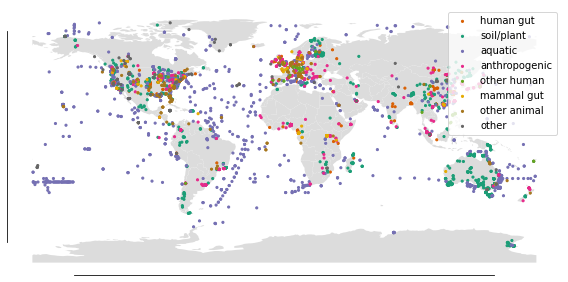

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="gainsboro", ax=ax)

for hab,c in color_map.items():
    sel = nmeta.query('higher == @hab')
    sel.plot(x="longitude", y="latitude", kind="scatter",
        c=[c for _ in range(len(sel))], label=hab,
        colormap="YlOrRd", s=4.5, ax=ax)

sns.despine(fig, trim=True)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(left=False,
               labelleft=False,
               bottom=False,
               labelbottom=False)
#fig.show()
fig.tight_layout()
ax.legend(loc=1)

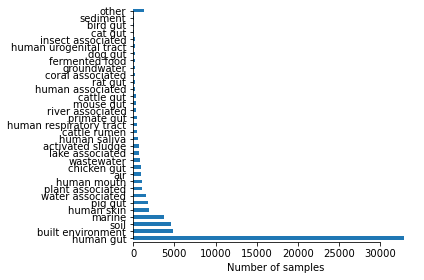

In [5]:
fig,ax = plt.subplots()
general = meta['general_envo_name'].value_counts()
general = general[general > 100]
general['other'] = len(meta) - general.sum()
general.plot(kind='barh', ax=ax)
ax.set_xlabel('Number of samples')
sns.despine(fig, trim=True)
fig.tight_layout()

In [6]:
samples = pd.read_table('data/samples-min500k-assembly-prodigal-stats.tsv.gz', index_col=0)
gmsc = pd.read_table("data/gmsc_amp_genes_envohr_source.tsv.gz")

gmsc = gmsc[gmsc.is_metagenomic == True]
gmsc = gmsc.groupby('sample').agg('size')

samples = pd.concat([samples, gmsc], axis=1).rename({0: 'ampsphere_amps'}, axis=1)

meta = pd.concat([meta, samples], axis=1)

meta['smorfs_per_assembly_mbps'] = meta.eval('1_000_000 * smORFs/assembly_total_length')
meta['ampsphere_amps_per_assembly_mbps'] = meta.eval('1_000_000 * ampsphere_amps/assembly_total_length')
meta = meta[~meta.ampsphere_amps.isna()]

inserts_filtered = meta.groupby('general_envo_name').sum()['inserts_filtered']
inserts_filtered = inserts_filtered.reindex(general.index)
inserts_filtered['other'] = meta['inserts_filtered'].sum() - inserts_filtered.sum()
inserts_filtered //= 1000_000_000

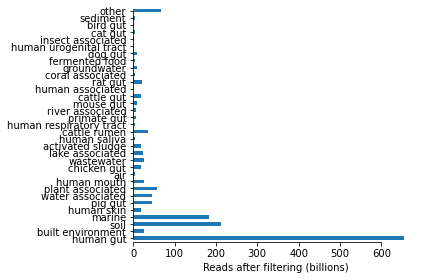

In [7]:
fig, ax = plt.subplots()
inserts_filtered.plot(kind='barh', ax=ax)
ax.set_xlabel('Reads after filtering (billions)')
sns.despine(fig, trim=True)
fig.tight_layout()

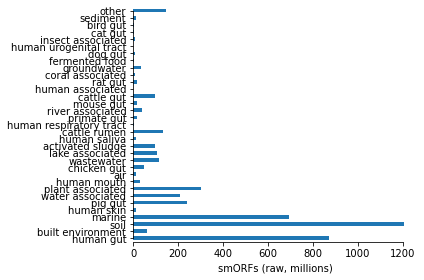

In [8]:
smORFs = meta.groupby('general_envo_name').sum()['smORFs']
smORFs = smORFs.reindex(general.index)
smORFs['other'] = meta['smORFs'].sum() - smORFs.sum()

fig, ax = plt.subplots()
(smORFs // 1000_000).plot(kind='barh', ax=ax)
ax.set_xlabel('smORFs (raw, millions)')
sns.despine(fig, trim=True)
fig.tight_layout()

In [9]:
assembly_total_length = meta.groupby('general_envo_name').sum()['assembly_total_length']
assembly_total_length = assembly_total_length.reindex(general.index)
assembly_total_length['other'] = meta['assembly_total_length'].sum() - assembly_total_length.sum()

meta['is_host_associated'] = meta['general_envo_name'].map(lambda c : is_host_associated[higher_level.get(c, 'other')])
meta['is_host_associated'] = meta.is_host_associated.map(lambda i: 'host' if i else 'non-host')

In [10]:
# remove outliers
q1, q3 = meta.ampsphere_amps_per_assembly_mbps.quantile([0.25,0.75])
iqr = q3-q1
ll, ul = q1-(1.5*iqr), q3+(1.5*iqr)

sel = meta[(meta.ampsphere_amps_per_assembly_mbps <= ul) & (meta.ampsphere_amps_per_assembly_mbps >= ll)]

In [11]:
# exclude habitats with less than 100 samples
count_envo = sel['general_envo_name'].value_counts()
count_envo = count_envo[count_envo >= 100]

sel = sel[sel.general_envo_name.isin(count_envo.index)]  # at least 100 samples

order = sel.groupby('general_envo_name').median()['ampsphere_amps_per_assembly_mbps'].sort_values().index

In [12]:
# sampling 100 random points per habitat
sels = []
for h in order:
    cur = sel[sel.general_envo_name == h]
    sels.append(cur.sample(100))

sels=pd.concat(sels)

/home/celio/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 17.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0, 0.5, 'AMPs per assembled Mbp')

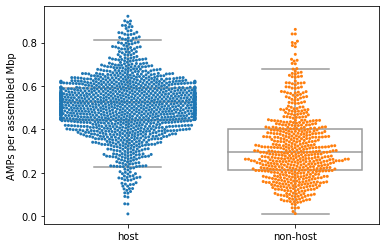

In [13]:
fig,ax = plt.subplots()
ax.set_xlim(-1,2)

sns.boxplot(x='is_host_associated',
        y='ampsphere_amps_per_assembly_mbps',
        order=['host', 'non-host'],
        ax=ax,
        showfliers=False,
        data=sel.sample(2000),
        color='white',
        )

sns.swarmplot(x='is_host_associated',
        y='ampsphere_amps_per_assembly_mbps',
        order=['host', 'non-host'],
        ax=ax,
        data=sel.sample(2000),
        s=3,
        )

plt.xlabel('')
plt.ylabel('AMPs per assembled Mbp')

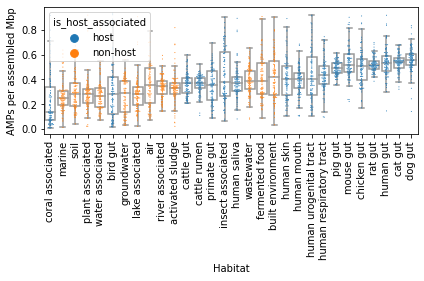

In [14]:
fig,ax = plt.subplots()

sns.boxplot(x='general_envo_name',
        y='ampsphere_amps_per_assembly_mbps',
        order=order,
        ax=ax,
        color='white',
        showfliers=False,
        data=sels)

sns.swarmplot(x='general_envo_name',
        y='ampsphere_amps_per_assembly_mbps',
        hue='is_host_associated',
        order=order,
        ax=ax,
        data=sels,
        s=1.0)

for x in ax.get_xticklabels():
    x.set_rotation(90)

plt.xlabel('Habitat')
plt.ylabel('AMPs per assembled Mbp')
plt.tight_layout()

In [15]:
x = sel.query('higher == "anthropogenic"')
x.groupby('general_envo_name').mean()['ampsphere_amps_per_assembly_mbps'].sort_values()

u, p = stats.mannwhitneyu(sel[sel.is_host_associated == 'host']['ampsphere_amps_per_assembly_mbps'],
                          sel[sel.is_host_associated == 'non-host']['ampsphere_amps_per_assembly_mbps'])

print(f'Host vs. non-host > Mann-WhitneyU = {u}, p-value = {p}')                          

Host vs. non-host > Mann-WhitneyU = 612861355.5, p-value = 0.0


In [16]:
# test AMP density differences of samples from different animal guts
sps = ['human gut', 'cat gut',
       'dog gut', 'chicken gut',
       'pig gut', 'cattle gut',
       'mouse gut', 'rat gut',
       'primate gut']

tests = []
for s, sn in combinations(sps, 2):
    u, p = stats.mannwhitneyu(sel[sel.general_envo_name == s]['ampsphere_amps_per_assembly_mbps'],
                              sel[sel.general_envo_name == sn]['ampsphere_amps_per_assembly_mbps'])
    tests.append((s, sn, u, p))

tests = pd.DataFrame(tests, columns=['s1', 's2', 'U', 'pval'])
_, tests['p_adj'], _, _ = multipletests(tests['pval'], method='hs')

# eliminate bxa and axb keeping the first seen
tests = tests.groupby('p_adj')
tests = tests.apply(lambda x: x.head(1))
tests = tests.reset_index(drop=True)

# fix name of habitat
tests.loc[:, 's1'] = tests['s1'].str.replace('primate', 'non-human primate')
tests.loc[:, 's2'] = tests['s2'].str.replace('primate', 'non-human primate')

tests.rename({'s1': 'Species 1',
              's2': 'Species 2',
              'p_adj': 'Adjusted p-value'},
             axis=1,
             inplace=True)
                          
tests.drop('pval', axis=1, inplace=True)
tests = tests.sort_values(by='Adjusted p-value')
tests

Species 1              Species 2           U  Adjusted p-value
0     human gut             cattle gut   9811662.0     8.438073e-124
1     human gut  non-human primate gut  10258995.0     7.764899e-111
2       pig gut             cattle gut    531047.0     1.052030e-108
3       pig gut  non-human primate gut    534542.0      1.834962e-79
4   chicken gut             cattle gut    248832.0      3.609401e-68
5    cattle gut                rat gut      7363.0      7.223671e-65
6    cattle gut              mouse gut     16991.0      4.968724e-64
7     human gut                pig gut  34503314.0      4.535947e-61
8       dog gut             cattle gut     60008.0      4.473962e-59
9   chicken gut  non-human primate gut    256784.0      1.373722e-54
10      dog gut  non-human primate gut     63241.0      8.765898e-53
11      rat gut  non-human primate gut     80203.0      1.153620e-50
12    mouse gut  non-human primate gut    114534.0      6.393778e-49
13      cat gut             cattle gut     40043.0      3.873262e-43
14      cat gut  non-human primate gut     41804.0      1.256114e-36
15      dog gut                pig gut    234109.0      1.259525e-24
16    human gut            chicken gut  16283596.0      3.958741e-16
17      dog gut            chicken gut    106718.0      5.296782e-12
18      cat gut                pig gut    145771.0      3.700243e-10
19      dog gut                rat gut     30398.0      1.074084e-08
20      dog gut              mouse gut     43461.0      1.239722e-06
21      pig gut                rat gut    170832.0      1.389075e-05
22      cat gut            chicken gut     66743.0      1.297189e-04
23    human gut                dog gut   2494869.0      2.555519e-03
24      cat gut                rat gut     18519.0      6.981455e-03
25    human gut              mouse gut   6557091.0      7.837657e-03
26    human gut                rat gut   4404382.0      1.858123e-02
27      cat gut              mouse gut     26918.0      2.885162e-02
28  chicken gut                rat gut     93179.0      3.327426e-02
29      pig gut              mouse gut    291084.0      5.619287e-02
30      cat gut                dog gut      9595.0      1.035092e-01
31  chicken gut              mouse gut    148030.0      2.135789e-01
32    mouse gut                rat gut     42296.0      5.412195e-01
33    human gut                cat gut   1928491.0      8.429378e-01

Text(0, 0.5, 'counts')

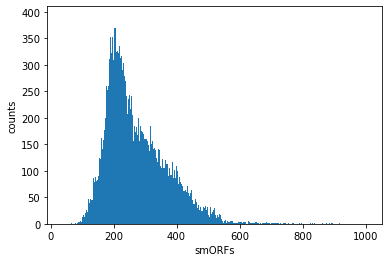

In [17]:
c = sel.smorfs_per_assembly_mbps.copy()

fig,ax = plt.subplots()
ax.clear()
ax.hist(c, bins=1000)
plt.xlabel('smORFs')
plt.ylabel('counts')

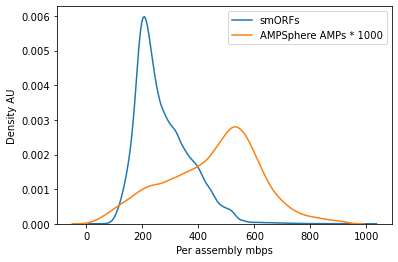

In [18]:
d = sel.ampsphere_amps_per_assembly_mbps.copy()

sns.kdeplot(data=c, label='smORFs')
sns.kdeplot(data=d*1000, label='AMPSphere AMPs * 1000')
plt.xlabel('Per assembly mbps')
plt.ylabel('Density AU')
plt.legend()

In [19]:
# get supplementary info
m = meta[['ena_ers_sample_id', 'database', 'access_status', 'study', 'study_accession',
          'general_envo_name', 'higher', 'inserts_filtered', 'assembly_total_length',
          'smORFs', 'ampsphere_amps', 'is_host_associated']].copy()

m.rename({'higher': 'macro_environment',
          'general_envo_name': 'micro_environment'},
         axis=1,
         inplace=True)
          
m.reset_index(drop=True)

ena_ers_sample_id database access_status                        study  \
0        SAMEA104408691      ENA        public  Alneberg_2018_marine_baltic   
1        SAMEA104408692      ENA        public  Alneberg_2018_marine_baltic   
2        SAMEA104408693      ENA        public  Alneberg_2018_marine_baltic   
3        SAMEA104408694      ENA        public  Alneberg_2018_marine_baltic   
4        SAMEA104408623      ENA        public  Alneberg_2018_marine_baltic   
...                 ...      ...           ...                          ...   
61388      SAMN09389011      SRA        public             Zhang_2018_panda   
61389      SAMN09389012      SRA        public             Zhang_2018_panda   
61390      SAMN09389013      SRA        public             Zhang_2018_panda   
61391      SAMN09389014      SRA        public             Zhang_2018_panda   
61392      SAMN09389015      SRA        public             Zhang_2018_panda   

                             study study_accession study_accession  \
0      Alneberg_2018_marine_baltic      PRJEB22997      PRJEB22997   
1      Alneberg_2018_marine_baltic      PRJEB22997      PRJEB22997   
2      Alneberg_2018_marine_baltic      PRJEB22997      PRJEB22997   
3      Alneberg_2018_marine_baltic      PRJEB22997      PRJEB22997   
4      Alneberg_2018_marine_baltic      PRJEB22997      PRJEB22997   
...                            ...             ...             ...   
61388             Zhang_2018_panda     PRJNA475184     PRJNA475184   
61389             Zhang_2018_panda     PRJNA475184     PRJNA475184   
61390             Zhang_2018_panda     PRJNA475184     PRJNA475184   
61391             Zhang_2018_panda     PRJNA475184     PRJNA475184   
61392             Zhang_2018_panda     PRJNA475184     PRJNA475184   

      micro_environment macro_environment  inserts_filtered  \
0                marine           aquatic          11644657   
1                marine           aquatic          27776957   
2                marine           aquatic          19765633   
3                marine           aquatic          24154664   
4                marine           aquatic          16295158   
...                 ...               ...               ...   
61388          deer gut        mammal gut          27280597   
61389          deer gut        mammal gut          24147336   
61390          deer gut        mammal gut          27300004   
61391          deer gut        mammal gut          32138141   
61392          deer gut        mammal gut          38428054   

       assembly_total_length  smORFs  ampsphere_amps is_host_associated  
0                   41424868   14517            11.0           non-host  
1                  359020538  110862            90.0           non-host  
2                  261200747   78382            24.0           non-host  
3                  300925052   93108            63.0           non-host  
4                  180650884   69948            44.0           non-host  
...                      ...     ...             ...                ...  
61388              374885234  132288            38.0               host  
61389              223416704  100386            18.0               host  
61390              335096796  124419            31.0               host  
61391              401438627  148947            43.0               host  
61392              490123181  181864            65.0               host  

[61393 rows x 14 columns]